In [1]:
# Instalação e configuração de variaveis ambiente para utilizar Google Drive
# Se utilizar o Colab ajustar para True para instalação dos pre-requisitos
import os
import sys

colab = True

if colab==True:
  from google.colab import drive
  drive.mount('/content/drive')

  !pip install optuna
  !pip install category_encoders
  !pip install catboost

  # Variaveis de configuração
  # Diretorio base dos dados
  # Google Drive
  dir_base = "/content/drive/MyDrive/jupyter/pcd_0124_analise_de_credito/data/"
else:
  # Variaveis de configuração
  # Diretorio base dos dados
  # Local PC
  dir_base = "data/"

# Importe de bibliotecas utilizadas no projeto

import math
import datetime
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import pandas            as pd
import seaborn           as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, ShuffleSplit
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, \
HistGradientBoostingClassifier,StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, make_scorer, accuracy_score, precision_score, recall_score, auc
import optuna
import pickle
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.4 MB/s eta 0:00:00


In [2]:
# Funções auxiliares

# Métricas do modelo

def calculate_metrics(nm_modelo, model, X_train, y_train, X_test, y_test):
    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })
    return metrics_df

def plot_metrics(model, X_train, y_train, X_test, y_test, features):
    plt.figure(figsize=(15, 18))

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [3]:
# Leitura dos dados

df_train = pd.read_csv(dir_base + 'bases_tratadas/treino_full_vars_selecionadas.csv')
df_test = pd.read_csv(dir_base + 'bases_tratadas/teste_full_vars_selecionadas.csv')

df_train.rename(columns={'SK_ID_CURR':'SK_ID_CURR','TARGET':'TARGET'},inplace=True)
df_test.rename(columns={'SK_ID_CURR':'SK_ID_CURR'},inplace=True)

In [4]:
df_train.head()

,VL_MED_AMT_GOODS_PRICE_ULTIMOS_6_MESES_PREVIOUS_APPLICATION,VL_MIN_HOUR_APPR_PROCESS_START_ULTIMOS_6_MESES_PREVIOUS_APPLICATION,VL_MIN_QT_MIN_AMT_PAYMENT_ULTIMOS_3_MESES_INSTALLMENTS_ULTIMOS_12_MESES_PREVIOUS_APPLICATION,QT_MAX_QT_MIN_DAYS_ENTRY_PAYMENT_ULTIMOS_3_MESES_INSTALLMENTS_ULTIMOS_12_MESES_PREVIOUS_APPLICATION,VL_MAX_QT_TOT_NUM_INSTALMENT_NUMBER_ULTIMOS_3_MESES_INSTALLMENTS_ULTIMOS_12_MESES_PREVIOUS_APPLICATION,VL_MAX_QT_MIN_NUM_INSTALMENT_VERSION_ULTIMOS_3_MESES_INSTALLMENTS_ULTIMOS_12_MESES_PREVIOUS_APPLICATION,VL_TOT_NFLAG_INSURED_ON_APPROVAL_ULTIMOS_12_MESES_PREVIOUS_APPLICATION,VL_TOT_QT_MIN_AMT_CREDIT_SUM_ULTIMOS_6_MESES,VL_MIN_QT_MAX_AMT_CREDIT_SUM_ULTIMOS_6_MESES,VL_MED_QT_MIN_AMT_CREDIT_SUM_ULTIMOS_6_MESES,...,var_10,var_9,var_8,var_6,var_5,var_4,var_2,var_1,SK_ID_CURR,TARGET
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.875325,0.140196,0.219610,0.549412,0.178447,0.981696,0.221163,0.063719,100010,0
1,64561.5,11.0,NaN,NaN,NaN,NaN,1.0,165240.0,165240.0,165240.0,...,0.292047,0.501912,0.792883,0.659842,0.057644,0.180723,0.913770,0.868715,100263,0
2,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.149897,0.633062,0.419009,0.990876,0.821471,0.261996,0.281130,0.890618,100320,0
3,NaN,NaN,14558.85,-77.0,15.0,1.0,1.0,135000.0,135000.0,135000.0,...,0.149429,0.574268,0.819266,0.461676,0.316989,0.462823,0.403110,0.984063,100704,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.953818,0.130448,0.274739,0.548212,0.568924,0.780728,0.091211,0.255818,100768,0


In [5]:
# Preparação dos Dados

#df_test.drop(columns='SK_ID_CURR',inplace=True)

X = df_train.drop(columns=['SK_ID_CURR','TARGET'])
y = df_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

cat_attributes = X_train.select_dtypes(include='object')
num_attributes = X_train.select_dtypes(exclude='object')

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_attributes.columns),
    ('num', num_pipe, num_attributes.columns)
])
preprocesssor = Pipeline(steps=[("preprocessor", preprocessor)])

X_train_processed = pd.DataFrame(preprocesssor.fit_transform(X_train, y_train),columns=X_train.columns)
X_test_processed = pd.DataFrame(preprocesssor.transform(X_test),columns=X_test.columns)

X_prod_processed = pd.DataFrame(preprocesssor.transform(df_test),columns=df_test.columns)

In [6]:
# Testar algoritmos

# Testar outros modelos

algoritmos = [DecisionTreeClassifier(criterion='gini',random_state=0),
            LogisticRegression(solver='liblinear',random_state=0),
            RandomForestClassifier(random_state=0),
            GradientBoostingClassifier(random_state=0),
            XGBClassifier(random_state=0),
            lgb.LGBMClassifier(random_state=0)]

for algoritmo in algoritmos:

    nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
    # Treino do modelo
    algoritmo.fit(X_train_processed,y_train)

    # Avaliar modelo
    metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
    display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,DecisionTreeClassifier,Treino,1.000000,1.000000,1.000000,1.00000,1.00000,1.000000
1,DecisionTreeClassifier,Teste,0.852945,0.142536,0.164696,0.53896,0.07792,0.084032


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LogisticRegression,Treino,0.919143,0.530086,0.013266,0.747632,0.495264,0.368829
1,LogisticRegression,Teste,0.919609,0.527273,0.016729,0.743386,0.486771,0.367622


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,0.999971,1.0,0.999641,1.000000,1.00000,1.000
1,RandomForestClassifier,Teste,0.919539,1.0,0.000865,0.702465,0.40493,0.297


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,GradientBoostingClassifier,Treino,0.920026,0.695260,0.022087,0.769395,0.538791,0.400727
1,GradientBoostingClassifier,Teste,0.919516,0.508333,0.017594,0.754081,0.508162,0.383928


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,XGBClassifier,Treino,0.931216,0.939331,0.160990,0.910738,0.821476,0.653925
1,XGBClassifier,Teste,0.918378,0.438320,0.048168,0.738695,0.477390,0.359645


[LightGBM] [Info] Number of positive: 13945, number of negative: 158260
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.340327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23864
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080979 -> initscore=-2.429118
[LightGBM] [Info] Start training from score -2.429118


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.921257,0.793893,0.037289,0.828111,0.656223,0.498167
1,LGBMClassifier,Teste,0.919957,0.566038,0.025959,0.755326,0.510652,0.382172


In [7]:
# Ideias de fature Engineering

# ----------------------------------------------- TREINO
# AMT_CREDIT
X_train_processed['APPS_ANNUITY_CREDIT_RATIO'] = X_train_processed['AMT_ANNUITY']/X_train_processed['AMT_CREDIT']
X_train_processed['APPS_GOODS_CREDIT_RATIO'] = X_train_processed['AMT_GOODS_PRICE']/X_train_processed['AMT_CREDIT']

# AMT_INCOME_TOTAL
X_train_processed['APPS_ANNUITY_INCOME_RATIO'] = X_train_processed['AMT_ANNUITY']/X_train_processed['AMT_INCOME_TOTAL']
X_train_processed['APPS_CREDIT_INCOME_RATIO'] = X_train_processed['AMT_CREDIT']/X_train_processed['AMT_INCOME_TOTAL']
X_train_processed['APPS_GOODS_INCOME_RATIO'] = X_train_processed['AMT_GOODS_PRICE']/X_train_processed['AMT_INCOME_TOTAL']

# DAYS_BIRTH, DAYS_EMPLOYED
X_train_processed['APPS_EMPLOYED_BIRTH_RATIO'] = X_train_processed['DAYS_EMPLOYED']/X_train_processed['DAYS_BIRTH']
X_train_processed['APPS_INCOME_EMPLOYED_RATIO'] = X_train_processed['AMT_INCOME_TOTAL']/X_train_processed['DAYS_EMPLOYED']
X_train_processed['APPS_INCOME_BIRTH_RATIO'] = X_train_processed['AMT_INCOME_TOTAL']/X_train_processed['DAYS_BIRTH']
X_train_processed['APPS_CAR_BIRTH_RATIO'] = X_train_processed['OWN_CAR_AGE'] / X_train_processed['DAYS_BIRTH']
X_train_processed['APPS_CAR_EMPLOYED_RATIO'] = X_train_processed['OWN_CAR_AGE'] / X_train_processed['DAYS_EMPLOYED']

# ----------------------------------------------- TESTE
# AMT_CREDIT
X_test_processed['APPS_ANNUITY_CREDIT_RATIO'] = X_test_processed['AMT_ANNUITY']/X_test_processed['AMT_CREDIT']
X_test_processed['APPS_GOODS_CREDIT_RATIO'] = X_test_processed['AMT_GOODS_PRICE']/X_test_processed['AMT_CREDIT']

# AMT_INCOME_TOTAL
X_test_processed['APPS_ANNUITY_INCOME_RATIO'] = X_test_processed['AMT_ANNUITY']/X_test_processed['AMT_INCOME_TOTAL']
X_test_processed['APPS_CREDIT_INCOME_RATIO'] = X_test_processed['AMT_CREDIT']/X_test_processed['AMT_INCOME_TOTAL']
X_test_processed['APPS_GOODS_INCOME_RATIO'] = X_test_processed['AMT_GOODS_PRICE']/X_test_processed['AMT_INCOME_TOTAL']

# DAYS_BIRTH, DAYS_EMPLOYED
X_test_processed['APPS_EMPLOYED_BIRTH_RATIO'] = X_test_processed['DAYS_EMPLOYED']/X_test_processed['DAYS_BIRTH']
X_test_processed['APPS_INCOME_EMPLOYED_RATIO'] = X_test_processed['AMT_INCOME_TOTAL']/X_test_processed['DAYS_EMPLOYED']
X_test_processed['APPS_INCOME_BIRTH_RATIO'] = X_test_processed['AMT_INCOME_TOTAL']/X_test_processed['DAYS_BIRTH']
X_test_processed['APPS_CAR_BIRTH_RATIO'] = X_test_processed['OWN_CAR_AGE'] / X_test_processed['DAYS_BIRTH']
X_test_processed['APPS_CAR_EMPLOYED_RATIO'] = X_test_processed['OWN_CAR_AGE'] / X_test_processed['DAYS_EMPLOYED']

# ----------------------------------------------- BASE DE ESCORAGEM
# AMT_CREDIT
X_prod_processed['APPS_ANNUITY_CREDIT_RATIO'] = X_prod_processed['AMT_ANNUITY']/X_prod_processed['AMT_CREDIT']
X_prod_processed['APPS_GOODS_CREDIT_RATIO'] = X_prod_processed['AMT_GOODS_PRICE']/X_prod_processed['AMT_CREDIT']

# AMT_INCOME_TOTAL
X_prod_processed['APPS_ANNUITY_INCOME_RATIO'] = X_prod_processed['AMT_ANNUITY']/X_prod_processed['AMT_INCOME_TOTAL']
X_prod_processed['APPS_CREDIT_INCOME_RATIO'] = X_prod_processed['AMT_CREDIT']/X_prod_processed['AMT_INCOME_TOTAL']
X_prod_processed['APPS_GOODS_INCOME_RATIO'] = X_prod_processed['AMT_GOODS_PRICE']/X_prod_processed['AMT_INCOME_TOTAL']

# DAYS_BIRTH, DAYS_EMPLOYED
X_prod_processed['APPS_EMPLOYED_BIRTH_RATIO'] = X_prod_processed['DAYS_EMPLOYED']/X_prod_processed['DAYS_BIRTH']
X_prod_processed['APPS_INCOME_EMPLOYED_RATIO'] = X_prod_processed['AMT_INCOME_TOTAL']/X_prod_processed['DAYS_EMPLOYED']
X_prod_processed['APPS_INCOME_BIRTH_RATIO'] = X_prod_processed['AMT_INCOME_TOTAL']/X_prod_processed['DAYS_BIRTH']
X_prod_processed['APPS_CAR_BIRTH_RATIO'] = X_prod_processed['OWN_CAR_AGE'] / X_prod_processed['DAYS_BIRTH']
X_prod_processed['APPS_CAR_EMPLOYED_RATIO'] = X_prod_processed['OWN_CAR_AGE'] / X_prod_processed['DAYS_EMPLOYED']

In [8]:
# Testar algoritmos após feature engineering
# Testar outros modelos após feature engineering

algoritmos = [DecisionTreeClassifier(criterion='gini',random_state=0),
            LogisticRegression(solver='liblinear',random_state=0),
            RandomForestClassifier(random_state=0),
            GradientBoostingClassifier(random_state=0),
            XGBClassifier(random_state=0),
            lgb.LGBMClassifier(random_state=0)]

for algoritmo in algoritmos:

    nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
    # Treino do modelo
    algoritmo.fit(X_train_processed,y_train)

    # Avaliar modelo
    metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
    display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,DecisionTreeClassifier,Treino,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,DecisionTreeClassifier,Teste,0.855756,0.146976,0.164696,0.540489,0.080977,0.085669


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LogisticRegression,Treino,0.919131,0.527536,0.013051,0.747766,0.495532,0.369845
1,LogisticRegression,Teste,0.919655,0.537037,0.016729,0.743498,0.486995,0.366800


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,0.999971,1.0,0.999641,1.000000,1.000000,1.000000
1,RandomForestClassifier,Teste,0.919539,1.0,0.000865,0.707531,0.415062,0.310243


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,GradientBoostingClassifier,Treino,0.920206,0.72467,0.023593,0.769627,0.539254,0.401114
1,GradientBoostingClassifier,Teste,0.919655,0.53125,0.019613,0.754761,0.509521,0.385039


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,XGBClassifier,Treino,0.931553,0.934031,0.166511,0.912862,0.825723,0.656889
1,XGBClassifier,Teste,0.918471,0.447689,0.053072,0.738356,0.476712,0.356484


[LightGBM] [Info] Number of positive: 13945, number of negative: 158260
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.357201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26181
[LightGBM] [Info] Number of data points in the train set: 172205, number of used features: 144
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080979 -> initscore=-2.429118
[LightGBM] [Info] Start training from score -2.429118


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.921622,0.823699,0.040875,0.830447,0.660893,0.500956
1,LGBMClassifier,Teste,0.919493,0.503106,0.023363,0.756773,0.513546,0.385150


In [9]:
# Tunagem de hiperparametros

import optuna

OPTUNA_EARLY_STOPING = 8

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = OPTUNA_EARLY_STOPING
    early_stop_count = 0
    best_score = None

def early_stopping_opt(study, trial):
    if EarlyStoppingExceeded.best_score == None:
      EarlyStoppingExceeded.best_score = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
      if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
      else:
            EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1
    #print(f'EarlyStop counter: {EarlyStoppingExceeded.early_stop_count}, Best score: {study.best_value} and {EarlyStoppingExceeded.best_score}')
    return



In [10]:
#LightGBM

# FYI: Objective functions can take additional arguments
# (https://optuna.readthedocs.io/en/stable/faq.html#objective-func-additional-args).
def objective(trial):

    param = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 20.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 20.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.05, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.05, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    cv = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True)
    avg_roc = 0
    for tr, ts in cv.split(X_train, y_train):
        Xtr, Xvl = X_train.iloc[tr], X_train.iloc[ts]
        ytr, yvl = y_train.iloc[tr], y_train.iloc[ts]
        model = lgb.LGBMClassifier(**param,random_state = 0)
        Xtr_processed = pd.DataFrame(preprocesssor.fit_transform(Xtr, ytr),columns=X_train.columns)
        Xvl_processed = pd.DataFrame(preprocesssor.transform(Xvl),columns=X_test.columns)
        model.fit(Xtr_processed,ytr)
        p = model.predict_proba(Xvl_processed)[:, 1]
        avg_roc += roc_auc_score(yvl, p)

    return avg_roc/5

study = optuna.create_study(direction="maximize",study_name="modelo", storage="sqlite:///modelo.db")
study.add_trials(study.trials)
try:
    study.optimize(objective, timeout=7200, callbacks=[early_stopping_opt])

    # reload study and optimize
    # study = optuna.load_study(study_name="pod-academy-study", storage="sqlite:///example.db")
    # study.optimize(objective, timeout=7200, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}')

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-04-04 10:43:16,754] A new study created in RDB with name: modelo
[I 2024-04-04 10:45:34,991] Trial 0 finished with value: 0.7419100656172266 and parameters: {'lambda_l1': 11.493353310541334, 'lambda_l2': 2.1583202830199058e-05, 'num_leaves': 243, 'feature_fraction': 0.5272526758683352, 'bagging_fraction': 0.48464720777340076, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 0 with value: 0.7419100656172266.
[I 2024-04-04 10:47:00,009] Trial 1 finished with value: 0.7490492495997957 and parameters: {'lambda_l1': 0.11174266618353562, 'lambda_l2': 1.575306763612875, 'num_leaves': 39, 'feature_fraction': 0.5560383769638952, 'bagging_fraction': 0.3654207698926402, 'bagging_freq': 9, 'min_child_samples': 19}. Best is trial 1 with value: 0.7490492495997957.
[I 2024-04-04 10:48:29,555] Trial 2 finished with value: 0.7068278563802289 and parameters: {'lambda_l1': 0.1284057271114392, 'lambda_l2': 0.24461407148749553, 'num_leaves': 74, 'feature_fraction': 0.6998739051607374, 'ba

EarlyStopping Exceeded: No new best scores on iters 8
Number of finished trials: 10
Best trial:
  Value: 0.7531378281659951
  Params: 
    lambda_l1: 1.0538318551438498e-05
    lambda_l2: 0.0005849398005237829
    num_leaves: 65
    feature_fraction: 0.47423396950685487
    bagging_fraction: 0.862903656210256
    bagging_freq: 10
    min_child_samples: 57


In [11]:
algoritmo = lgb.LGBMClassifier(**study.best_params,random_state = 0)

nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
# Treino do modelo
algoritmo.fit(X_train_processed,y_train)

# Avaliar modelo
metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
display(metricas)

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.47423396950685487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47423396950685487
[LightGBM] [Warning] lambda_l2 is set=0.0005849398005237829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005849398005237829
[LightGBM] [Warning] lambda_l1 is set=1.0538318551438498e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0538318551438498e-05
[LightGBM] [Warning] bagging_fraction is set=0.862903656210256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.862903656210256
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.47423396950685487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47423396950685487
[LightGBM] [Warning] lambda_l2 is set=0.00

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.924375,0.902269,0.074148,0.872763,0.745527,0.580785
1,LGBMClassifier,Teste,0.920073,0.558559,0.035766,0.754651,0.509302,0.388454


In [12]:
#Ordenação nos decis

#Treino

y_train.index = X_train_processed.index

bins = 10
tab = pd.concat([X_train_processed,y_train],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['TARGET']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='TARGET', aggfunc='mean'),
    volume=pd.NamedAgg(column='TARGET', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()/tab[tab.TARGET == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_train = table[['decile','event_rate','perc_total_bads']]
table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train'},inplace=True)
table_train

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.47423396950685487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47423396950685487
[LightGBM] [Warning] lambda_l2 is set=0.0005849398005237829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005849398005237829
[LightGBM] [Warning] lambda_l1 is set=1.0538318551438498e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0538318551438498e-05
[LightGBM] [Warning] bagging_fraction is set=0.862903656210256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.862903656210256


<ipython-input-12-7f9407009670>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train'},inplace=True)


,decile,event_rate_train,perc_total_bads_train
0,0,0.434063,0.536034
1,1,0.152207,0.187953
2,2,0.084141,0.103908
3,3,0.051452,0.063535
4,4,0.033099,0.040875
5,5,0.023229,0.028684
6,6,0.014576,0.017999
7,7,0.009697,0.011976
8,8,0.005285,0.006526
9,9,0.002032,0.002510


In [13]:
# Teste
y_test.index = X_test_processed.index

bins = 10
tab = pd.concat([X_test_processed,y_test],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['TARGET']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='TARGET', aggfunc='mean'),
    volume=pd.NamedAgg(column='TARGET', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()/tab[tab.TARGET == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_test = table[['decile','event_rate','perc_total_bads']]
table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test'},inplace=True)
table_test

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.47423396950685487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47423396950685487
[LightGBM] [Warning] lambda_l2 is set=0.0005849398005237829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005849398005237829
[LightGBM] [Warning] lambda_l1 is set=1.0538318551438498e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0538318551438498e-05
[LightGBM] [Warning] bagging_fraction is set=0.862903656210256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.862903656210256


<ipython-input-13-16a59a621021>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test'},inplace=True)


,decile,event_rate_test,perc_total_bads_test
0,0,0.266605,0.331122
1,1,0.146574,0.182002
2,2,0.106620,0.132391
3,3,0.084785,0.105278
4,4,0.056214,0.069801
5,5,0.044599,0.055379
6,6,0.034843,0.043265
7,7,0.028107,0.034900
8,8,0.022532,0.027978
9,9,0.014399,0.017883


In [14]:
summary = pd.merge(table_train,table_test,on='decile',how='inner')
summary

,decile,event_rate_train,perc_total_bads_train,event_rate_test,perc_total_bads_test
0,0,0.434063,0.536034,0.266605,0.331122
1,1,0.152207,0.187953,0.146574,0.182002
2,2,0.084141,0.103908,0.106620,0.132391
3,3,0.051452,0.063535,0.084785,0.105278
4,4,0.033099,0.040875,0.056214,0.069801
5,5,0.023229,0.028684,0.044599,0.055379
6,6,0.014576,0.017999,0.034843,0.043265
7,7,0.009697,0.011976,0.028107,0.034900
8,8,0.005285,0.006526,0.022532,0.027978
9,9,0.002032,0.002510,0.014399,0.017883


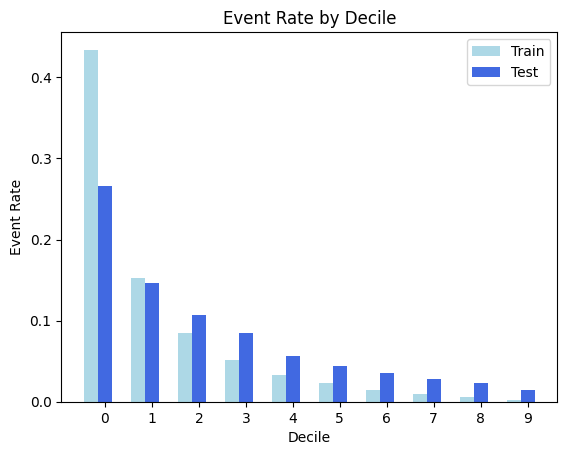

In [15]:
# Visualização Gráfica

# Plotando o gráfico de barras para Event Rate por Decil
barWidth = 0.3
r1 = np.arange(len(summary))
r2 = [x + barWidth for x in r1]

plt.bar(r1, summary['event_rate_train'], color='lightblue', width=barWidth, label='Train')
plt.bar(r2, summary['event_rate_test'], color='royalblue', width=barWidth, label='Test')

plt.xlabel('Decile')
plt.ylabel('Event Rate')
plt.title('Event Rate by Decile')
plt.xticks([r + barWidth for r in range(len(summary))], summary['decile'])
plt.legend()
plt.show()

In [17]:
# Escoragem
df_test = pd.read_csv(dir_base + 'bases_tratadas/teste_full_vars_selecionadas.csv')
#df_test.rename(columns={'SK_ID_CURR':'SK_ID_CURR'},inplace=True)
y_predict_proba_prod = algoritmo.predict_proba(X_prod_processed)[:,1]
df_submission = pd.DataFrame(df_test.SK_ID_CURR.values,columns=['ID'])
df_submission['TARGET'] = y_predict_proba_prod

df_submission.to_csv(dir_base + 'bases_tratadas/submission.csv', index=False)

[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.47423396950685487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47423396950685487
[LightGBM] [Warning] lambda_l2 is set=0.0005849398005237829, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005849398005237829
[LightGBM] [Warning] lambda_l1 is set=1.0538318551438498e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0538318551438498e-05
[LightGBM] [Warning] bagging_fraction is set=0.862903656210256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.862903656210256


AttributeError: 'DataFrame' object has no attribute 'SK_ID_CURR'

In [ ]:
# Salvar melhor modelo

import pickle

with open(dir_base + 'bases_tratadas/vars_lgbm.pkl', 'wb') as f:
    pickle.dump(X_train_processed.columns, f)

with open(dir_base + 'bases_tratadas/lgbm.pkl', 'wb') as file:
  pickle.dump(algoritmo, file)